# [Insert Creative Title HERE]

## Introduction and Motivation



## Required Libraries

This project requires a basic understanding of python. However, If you are not familiar with the language itself <br>
but are a strong programmer you should be able to follow along! Before continuing, please familiarize yourself with <br>
the following libraries as they will be used heavily:

Intro to Pandas:
https://pandas.pydata.org/pandas-docs/version/0.15/tutorials.html

Learning the Spotify API through spotipy:
https://spotipy.readthedocs.io/en/latest/#

Learning numpy:
https://docs.scipy.org/doc/numpy/reference/

Learning scikit: 
https://scikit-learn.org/stable/

It's not necessary to read these docs end to end but its a great idea to flip through each website at least once.


In [1]:
import sys
import pandas as pd
import numpy as np
import spotipy
import spotipy.util as util
import matplotlib.pyplot as plt
from sklearn import cluster, decomposition, metrics
import plotly.graph_objects as go
import seaborn as sns

## Data Collection and Tidying
The first step of any data science project is collecting data. We decided to use the spotipy api in order to <br>
collect a user's spotify library. To get access to a users data you must get authorization. The general<br>
flow is written out below.


Getting Username:<br>

If you use spotify directly, then your username is the one that you use to login. If you use facebook or another service for authentication then you must follow these steps(https://community.spotify.com/t5/Accounts/How-do-i-find-my-username-when-using-Facebook-login/td-p/859795) to retrieve your username:
1. Open the Spotify Desktop app.

2. Log in using your Facebook credentials.

3. Click on your name in the top right of the screen to go to your Profile (should show list of recently played artists/playlists/etc)

4. At the top of the screen on your Profile page, you should see your Name in really big letters. Right under your name is a circle with three dots in it (elipsis).

5. Click the clircle. and "Copy Spotify URI"

6. Paste the Spotify URI somewhere you can read it (notepad, word doc, search bar, whatever)

7. The string of digits is your REAL Spotify Username.

Scope: <br>
Since we will be reading from your spotify library we need the scope 'user-library-read'. We will also <br>
be writing to your spotify playlist so the scope 'playlist-modify-public' is needed as well.

Client_id, client_secret, redirect_uri:<br>
In order to get your own id, secret and uri you must go to https://developer.spotify.com/dashboard/applications and create a client id and secret. Make sure <br>
that the redirect uri that you choose is EXACTLY the same as what you input for the token. If not, the token won't
be able to be retrieved. <br> 

Another example can be found within the docs here: https://spotipy.readthedocs.io/en/latest/#authorization-code-flow

In [2]:
# Generate authorization token for reading user library
username = '12124976904'

scope = 'user-library-read playlist-modify-public'
client_id = '076ff5215a374d2481d0117877d79b74'
client_secret = '0ff2fd29106e4b7ebd7da4152d4a20c3'
redirect_uri = 'https://www.google.com/'

token = util.prompt_for_user_token(username, scope, client_id, client_secret, redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)

else:
    print("Can't get token for", username)
    sys.exit()

Data Collection: <br>

For this project we will be collecting the user's saved tracks from their library. A saved track on spotify just means that the user favorited it. 

We decided to split the user's data into two different data frames to make our lives easier later on. It is a lot easier/tidier to analyze the data with all the data that will be used for analysis and machine learning in one table seperate from the observation labels. <br>

The data is split into a features frame which consists of the feature observations for every song in the user's playlists. The features we decided to focus on were acousticness, danceability, energy, instrumentalness, tempo, and valence. Descriptions of these features can be found at https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/. All the features are standardized to be between zero and one by spotify's api. We had to manually standardize tempo to between zero and one using the equation in the code. <br>

The other dataframe we created is track_info. Each observation has a track title and an artist. <br>

IF YOU DON'T WANT TO USE YOU OWN DATA, SET THE IF STATEMENT TO FALSE AND USE THE SAMPLE DATA 

In [3]:
def get_saved_tracks():
    results = sp.current_user_saved_tracks() 
    tracks = results['items']
    while results['next']: #results are paginated. To retrieve all results keep requesting until no next
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

print('Loading Saved Tracks Now. Please be patient!') # This part of the code takes a while

if False:
    tracks = get_saved_tracks()
    features = []
    track_info = []
    artist_uris = {}
    
    for track in tracks:
        track = track['track']
        features.extend(sp.audio_features(track['uri'])) #Calling spotify api to retrieve a track's audio features
        track_info.append([track['name'], track['artists'][0]['name']])
        artist_uris[track['artists'][0]['name']] = track['artists'][0]['uri']

    features = pd.DataFrame(features)
    track_info = pd.DataFrame(track_info).rename(columns={0: "title", 1: "artist"})

    features = features[['acousticness', 'danceability', 'energy', 'instrumentalness', 'tempo', 'valence']]
    #Standardizing tempo
    features['tempo'] = (features['tempo']-features['tempo'].min())/(features['tempo'].max()-features['tempo'].min())
    
    features.to_csv('sample_features',index=False)
    track_info.to_csv('sample_track_info',index=False)

else:
    features = pd.read_csv('sample_features')
    track_info = pd.read_csv('sample_track_info')
    
features

Loading Saved Tracks Now. Please be patient!


,acousticness,danceability,energy,instrumentalness,tempo,valence
0,0.356000,0.586,0.918,0.001530,0.379245,0.310
1,0.880000,0.324,0.428,0.000013,0.784055,0.243
2,0.017500,0.810,0.731,0.000141,0.589816,0.622
3,0.011600,0.562,0.850,0.000000,0.470217,0.410
4,0.162000,0.725,0.680,0.000002,0.431567,0.760
...,...,...,...,...,...,...
423,0.000056,0.579,0.865,0.000221,0.333120,0.358
424,0.469000,0.576,0.451,0.038900,0.237295,0.803
425,0.360000,0.671,0.740,0.000000,0.214200,0.908
426,0.150000,0.424,0.875,0.000000,0.748454,0.440


## Exploratory Data Analysis & Visualizations

In [4]:
# Summary Statistics
# Histograms
# Correlation Graphs


In [5]:
features.describe()

,acousticness,danceability,energy,instrumentalness,tempo,valence
count,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000
mean,0.267391,0.651002,0.598219,0.027620,0.443832,0.450615
std,0.287885,0.154714,0.186267,0.122673,0.194017,0.228727
min,0.000041,0.240000,0.068200,0.000000,0.000000,0.037900
25%,0.030550,0.549500,0.479000,0.000000,0.288062,0.269250
50%,0.153000,0.670000,0.607500,0.000002,0.437718,0.415500
75%,0.407750,0.763000,0.741250,0.000479,0.592813,0.627250
max,0.979000,0.961000,0.988000,0.878000,1.000000,0.968000


In [6]:
corr = features.corr()
corr.style.background_gradient(cmap='coolwarm')

,acousticness,danceability,energy,instrumentalness,tempo,valence
acousticness,1,-0.377397,-0.588312,0.216891,-0.123963,-0.110016
danceability,-0.377397,1,0.132252,-0.009904,0.0516756,0.149749
energy,-0.588312,0.132252,1,-0.10783,0.0171763,0.397619
instrumentalness,0.216891,-0.009904,-0.10783,1,0.0393062,-0.142701
tempo,-0.123963,0.0516756,0.0171763,0.0393062,1,-0.104967
valence,-0.110016,0.149749,0.397619,-0.142701,-0.104967,1


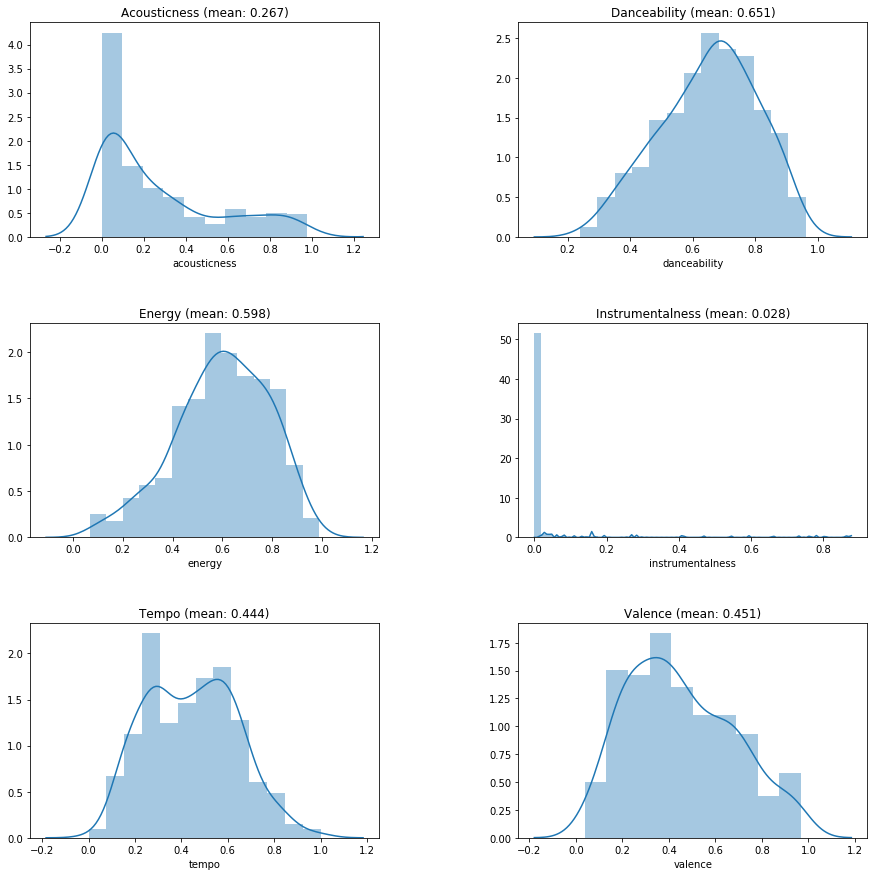

In [8]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

fig.set_figheight(15)
fig.set_figwidth(15)

ax = fig.add_subplot(3, 2, 1)
ax.set_title("Acousticness" + " (mean: " + str(np.round(features['acousticness'].mean(), 3)) + ")")
sns.distplot(features['acousticness'],ax=ax)

ax = fig.add_subplot(3, 2, 2)
ax.set_title("Danceability" + " (mean: " + str(np.round(features['danceability'].mean(), 3)) + ")")
sns.distplot(features['danceability'])

ax = fig.add_subplot(3, 2, 3)
ax.set_title("Energy" + " (mean: " + str(np.round(features['energy'].mean(), 3)) + ")")
sns.distplot(features['energy'])

ax = fig.add_subplot(3, 2, 4)
ax.set_title("Instrumentalness" + " (mean: " + str(np.round(features['instrumentalness'].mean(), 3)) + ")")
sns.distplot(features['instrumentalness'])

ax = fig.add_subplot(3, 2, 5)
ax.set_title("Tempo" + " (mean: " + str(np.round(features['tempo'].mean(), 3)) + ")")
sns.distplot(features['tempo'])

ax = fig.add_subplot(3, 2, 6)
ax.set_title("Valence" + " (mean: " + str(np.round(features['valence'].mean(), 3)) + ")")
sns.distplot(features['valence'])
plt.show()

## Machine Learning

### Clustering & Principal Component Analysis

In [ ]:
affinity = cluster.AffinityPropagation(preference=0).fit(features.values)
pref = 0
db_scores = {}

while (len(affinity.cluster_centers_) > 6):
    pref -= 1
    affinity = cluster.AffinityPropagation(preference=pref).fit(features.values)
    
    if len(affinity.cluster_centers_) <= 10 and len(affinity.cluster_centers_) >= 6:
        db_scores[metrics.davies_bouldin_score(features.values, affinity.labels_)] = affinity
    
db_scores

In [ ]:
clusters = db_scores[min(db_scores.keys())]
features['Cluster'] = clusters.labels_
track_info['Cluster'] = clusters.labels_
track_info.iloc[clusters.cluster_centers_indices_]

In [ ]:
#Can play with this to see the songs in each cluster
track_info.loc[track_info['Cluster'] == 0]

In [ ]:
pca = decomposition.PCA(n_components=2)
features_2d = pd.DataFrame(pca.fit_transform(features.loc[:,:'valence']), columns=['Component 1', 'Component 2'])
features_2d['Cluster'] = clusters.labels_
print(pca.explained_variance_ratio_)
features_2d.head(10)

In [ ]:
colors = ['red', 'orange', 'yellow', 'pink', 'green', 'blue', 'purple', 'black', 'cyan', 'grey']
fig, ax = plt.subplots(figsize=(16,11))
features_2d = features_2d.sort_values('Cluster')

for cluster_label in features_2d['Cluster'].unique():
    group = features_2d.loc[features_2d['Cluster'] == cluster_label]
    ax.scatter(group['Component 1'], group['Component 2'], c = colors[cluster_label], label=cluster_label, s=12)
    
ax.legend()

In [ ]:
fig, ax = plt.subplots(3, 2, sharex=True, figsize=(16, 15))
ax = ax.flatten()
idx = 0

for col in features.loc[:,:'valence'].columns:
    seaborn.violinplot(features['Cluster'], features[col], ax=ax[idx])
    ax[idx].set_title(col)
    idx += 1

In [ ]:
fig, ax = plt.subplots(int((len(clusters.cluster_centers_))/2) + 1, 2, sharex=True, figsize=(16, 15))
ax = ax.flatten()
idx = 0

for cluster_label in features['Cluster'].unique():
    group = features.loc[features['Cluster'] == cluster_label].drop('Cluster', axis=1)
    group = group.melt()
    seaborn.violinplot(x=group['variable'], y=group['value'], data=group, ax=ax[idx])
    ax[idx].set_title("Cluster " + str(cluster_label))
    idx += 1

### Finding Similar Songs

In [ ]:
artists = track_info.groupby('artist').count().drop('Cluster', axis=1)
artists = artists.reset_index().rename(columns={"title": "count"})
artists = artists.sort_values('count', ascending=False).head(25)
artists['uri'] = [artist_uris[artist] for artist in artists['artist']]
artists.head(5)

In [ ]:
related_tracks = []
known_artists = set(track_info['artist'])

for tup in artists.itertuples():
    for artist in sp.artist_related_artists(tup.uri)['artists'][:12]:
        
        if artist['name'] not in known_artists:
            known_artists.add(artist['name'])
            
            for track in sp.artist_top_tracks(artist['uri'])['tracks'][:5]:
                related_tracks.append([track['name'], track['artists'][0]['name'], track['uri']])
    
related_tracks = pd.DataFrame(related_tracks).rename(columns={0: "title", 1: "artist", 2: "uri"})
related_tracks

In [ ]:
rec_features = []

for uri in related_tracks['uri']:
    rec_features.extend(sp.audio_features(uri))

rec_features = pd.DataFrame(rec_features)
rec_features = rec_features[['acousticness', 'danceability', 'energy', 'instrumentalness', 'tempo', 'valence']]
rec_features['tempo'] = (rec_features['tempo']-rec_features['tempo'].min())/ \
                        (rec_features['tempo'].max()-rec_features['tempo'].min())
rec_features

In [ ]:
rec_features['cluster'] = clusters.predict(rec_features)
rec_features['silhouette'] = metrics.silhouette_samples(rec_features.loc[:'valence'], rec_features['cluster'])
rec_features[['title', 'artist', 'uri']] = related_tracks[['title', 'artist', 'uri']]
rec_features.head(10)

In [ ]:
grouped = rec_features.groupby('cluster').apply(lambda x: x.sort_values('silhouette', ascending=False).head(12))
grouped = grouped.reset_index(drop=True)

grouped.groupby('cluster').mean()['silhouette']

In [ ]:
#Can play with this to see the songs in each playlist
grouped.loc[grouped['cluster'] == 1]

In [ ]:
features_2d = pd.DataFrame(pca.fit_transform(grouped.loc[:,:'valence']), columns=['Component 1', 'Component 2'])
features_2d['cluster'] = grouped['cluster']

fig, ax = plt.subplots(figsize=(16,11))
features_2d = features_2d.sort_values('cluster')

for cluster_label in features_2d['cluster'].unique():
    group = features_2d.loc[features_2d['cluster'] == cluster_label]
    ax.scatter(group['Component 1'], group['Component 2'], c = colors[cluster_label], label=cluster_label, s=12)
    
ax.legend()

In [ ]:
fig, ax = plt.subplots(int((len(clusters.cluster_centers_ + 1))/2), 2, sharex=True, figsize=(16, 20))
ax = ax.flatten()
idx = 0

for cluster_label in grouped['cluster'].unique():
    saved = features.loc[features['Cluster'] == cluster_label].loc[:,:'valence'].mean()
    recs = grouped.loc[grouped['cluster'] == cluster_label].loc[:,:'valence'].mean()

    combined = pd.DataFrame(saved).rename(columns={0: "saved"})
    combined['recs'] = recs
    combined = combined.reset_index().melt(id_vars=['index'])
    seaborn.barplot(x=combined['index'], y=combined['value'], hue=combined['variable'], data=group, ax=ax[idx])
    
    idx += 1

In [ ]:
for cluster_label in grouped['cluster'].unique():
    cluster_rec = grouped.loc[grouped['cluster'] == cluster_label]
    feature_avgs = cluster_rec.mean().drop(['cluster', 'silhouette'])
    
    name = ""
    for feature in feature_avgs.keys():
        if feature_avgs[feature] < 0.2:
            name += "Low " + feature + ", "
        elif feature_avgs[feature] > 0.65:
            name += "High " + feature + ", "
    name = name[:-2]
    
    playlist = sp.user_playlist_create('12124976904', name)
    sp.user_playlist_add_tracks(username, playlist['id'], cluster_rec['uri'])

## Takeaways 